# ECBM E4070/6070 2024 Project 1 Handout

_Copyright 2024_ Shashwat Shukla, Bruce Yi Bu, and Aurel A. Lazar

### NAME and UNI
### Zhijie Zhan (zz3161), Jianjie Sun (js6412)

### Miscellaneous (attention)
* please remember to include your name in the corresponding field at the start of this notebook, otherwize an automatic 0 grade will be received for any missing member
* please submit one copy per team
* please clearly present your solutions and answers with proper use of plots, markdown and comments
* please start the project as soon as possible, submission deadlines are strictly followed and late submissions after we posted the solution (ususlly on the same day as the deadline) will receive automatic 0
* please email both TAs at least 48hrs ahead of deadline if you cannot submit an assignment on time (due to exam schedules or  overwhelming deadlines, etc), we are flexible as long as we are informed
* please post your questions on Ed Discussions, and attend the office hours (every Thursday evening); **more on Ed**:
    * while discussing on Ed, please make good use of the reply and comment features inside threads to avoid cluttering with multiple threads regarding the same question from the same user
    * please refrain from asking questions or posting threads that would explicitly share the right answer with everyone
    * only post code snipets when you have narrowed down the issue to that particular section and only share ploted results only when you have good reason to suspect their correctness
    * once you finish debugging your code by the end of a thread, please avoid languages such as "is this correct now?" since we aren't really allowed to explicitly say yes when they are; be confident in your hardwork
* please restart your kernel and run all cells and save before you submit, to ensure the submission does not have any bugs or cells out of order
   * any code that runs into bugs will not be graded.

### Setup

In [1]:
# import libraries #
import math
import numpy as np
np.random.seed(0)
from scipy.signal import convolve2d
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# specify simulation parameters #
dt = 5e-4 # timestep (sec)
T = 0.2 # total simulation time (sec)
t = np.arange(0, T, dt) # timesteps (sec)
N = len(t) # number of timesteps
W = 500 # screen width (pixels)
H = 250 # screen height (pixels)

In [3]:
# define static random background
background = np.random.random((W, H))

# specify moving rectangular dark objects
# ! specify speed and direction separately ! #
rect1 = {'dims': np.array([10, 10], dtype=int), # rectangle width, height (pixels)
         'p0': np.array([25, 25], dtype=int), # initial x,y position (pixels)
         'v': np.array([900, 900], dtype=int), # x,y velocity (pixels/sec)
        }
objects = [rect1] # collate objects

# simulate object motion trajectories
trajectories = [np.zeros((N, 2))] * len(objects)
for m, obj in enumerate(objects):
    trajectories[m][0] = obj['p0']
for i in range(1, N):
    # translate each object, with periodic screen boundaries
    for m, obj in enumerate(objects):
        trajectories[m][i] = np.remainder(trajectories[m][i-1] + dt * obj['v'], [W, H])

# store ground truth object trajectory data
ground_truth = []
for m, obj in enumerate(objects):
    entry = {'dims': obj['dims'], 
             'p': trajectories[m],
            }
    ground_truth.append(entry)

# create input frames
frames = []
for i in range(N):
    frame = np.copy(background)
    for gt in ground_truth:
        w, h = gt['dims']
        px, py = gt['p'][i].astype(int)
        # draw within screen bounds
        frame[np.max([0, px]):np.min([px+w, W]), 
              np.max([0, py]):np.min([py+h, H])] = 0
    frames.append(frame)
frames = np.array(frames)

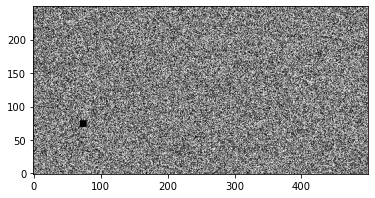

In [4]:
plt.imshow(frames[100].T, origin='lower', cmap='gray')
plt.show()

In [293]:
### Helper plot function
def plot_timestamps(data, time=(0, 20, 200)):
    plt.figure(dpi=150)
    plt.subplot(131)
    plt.imshow(data[time[0]].T, origin='lower', cmap='gray')
    plt.title('t=0ms')
    plt.subplot(132)
    plt.imshow(data[time[1]].T, origin='lower', cmap='gray')
    plt.title('t=10ms')
    plt.subplot(133)
    plt.imshow(data[time[2]].T, origin='lower', cmap='gray')
    plt.title('t=100ms')
    plt.show()

### Retina

In [158]:
# define retinal blur filter

def eq2_G(x,y, sigma=1):
    return np.exp(-(x*x+y*y)/(2*sigma*sigma))/(2*3.14159*sigma*sigma)

X = np.linspace(-5, 5, num=10)
Y = np.linspace(-5, 5, num=10)
X, Y = np.meshgrid(X,Y)
filter_eq2 = eq2_G(X,Y)

def eq1_P(I):
    P = convolve2d(np.array(I), np.array(filter_eq2), mode='same', boundary='symm')
    return P


In [159]:
# compute ommatidium output

P = []
for t in range(len(frames)):
    P.append(eq1_P(frames[t]))
#     P.append(gaussian_filter(frames[t], sigma=1))

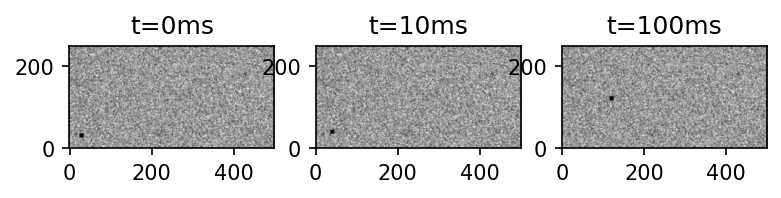

In [294]:
plot_timestamps(P)

### Lamina

In [163]:
# define gamma function
def eq5_gamma(t, n, tau):
    return (n*t)**n*np.exp(-n*t/tau)/(np.math.factorial(n-1)*tau**(n+1))

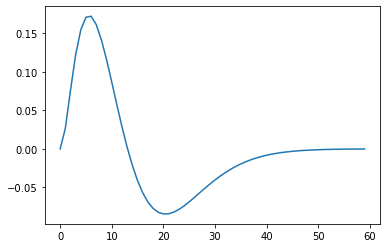

In [164]:
# define temporal derivative filter #
def eq4_H(t):
    return eq5_gamma(t, 2, 3) - eq5_gamma(t, 6, 9)

t_window = np.arange(0, 30, dt*1e3)
# t_window = np.linspace(0, 30, 30)
filter_eq4 = eq4_H(t_window)
plt.plot(filter_eq4) # Check if matches Fig.4

In [285]:
# compute LMC output #
L = convolve1d(P, filter_eq4, mode='nearest', axis=0)

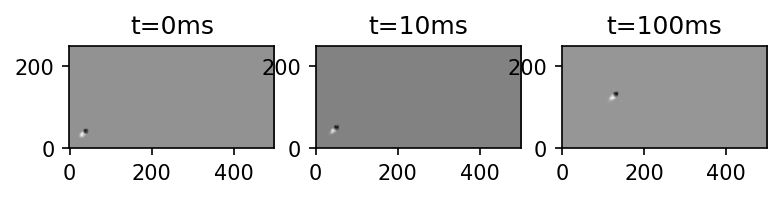

In [286]:
plot_timestamps(L)

In [106]:
# temporal trace kernels #
def eq10_WPT(t):
    lambda1=3
    return np.exp(-t/lambda1)/lambda1

def eq11_WNT(t):
    lambda2=9
    return np.exp(-t/lambda2)/lambda2

t_window = np.arange(0, 30, dt*1e4)
filter_eq10 = eq10_WPT(t_window)
filter_eq11 = eq11_WNT(t_window)

In [367]:
# spatial on-center and off-surround kernels #
def eq8_WPS(x,y):
    ans = eq2_G(x,y,1.5) - eq2_G(x,y,3)
    return np.maximum(ans, np.zeros_like(ans))
def eq9_WNS(x,y):
    ans = eq2_G(x,y,1.5) - eq2_G(x,y,3)
    return np.minimum(ans, np.zeros_like(ans))

filter_eq8 = eq8_WPS(X,Y)
filter_eq9 = eq9_WNS(X,Y)

In [368]:
# compute laterally inhibited LMC output, using space-time separable kernels #
# temporal filtering
# spatial filtering
# collate output

# Using 3d-filtering directly:
W_1 = np.outer(filter_eq10,filter_eq8).reshape(6, 10, 10) + np.outer(filter_eq11,filter_eq9).reshape(6, 10, 10)

from scipy.ndimage import convolve

L_I = convolve(L, W_1)

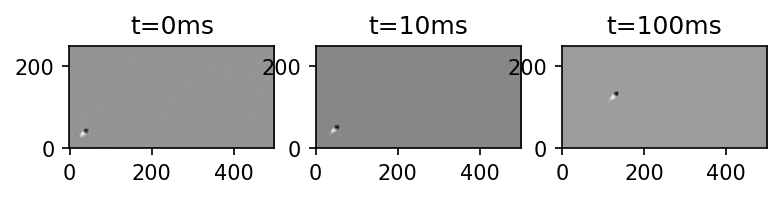

In [369]:
plot_timestamps(L_I)

### Medulla

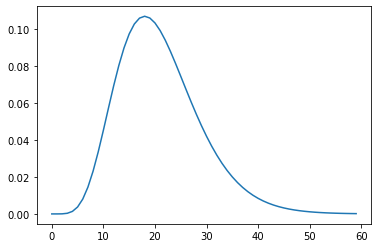

In [370]:
# temporal delay kernels #
def eq16_gamma(t, n=6, tau=9):
    return eq5_gamma(t, n, tau)

t_window = np.arange(0, 30, dt*1e3)
filter_eq16 = eq16_gamma(t_window)
plt.plot(filter_eq16) # Check if matches Fig.4

In [371]:
# compute celltype outputs to implement DSMTD #
# ON and delayed ON signals
S_Tm3 = np.clip(L_I, 0, np.inf)
S_Mi1 = convolve1d(S_Tm3, filter_eq16, mode='nearest', axis=0)

# OFF and delayed OFF signals
S_Tm2 = np.clip(L_I, -np.inf, 0)
S_Tm1 = convolve1d(S_Tm2, filter_eq16, mode='nearest', axis=0)


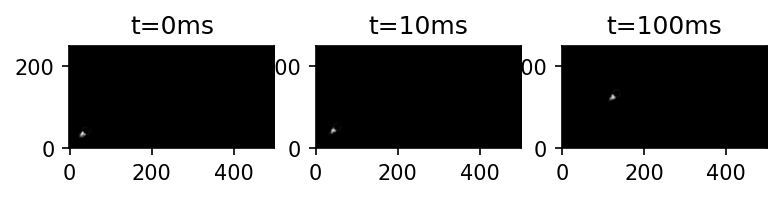

In [372]:
plot_timestamps(S_Tm3)

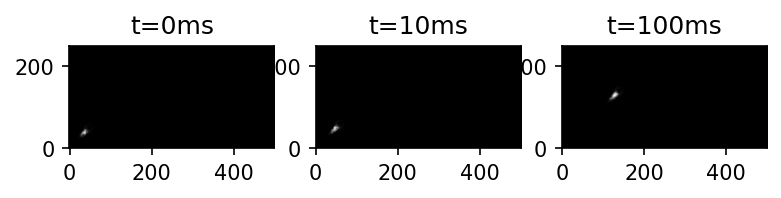

In [373]:
plot_timestamps(S_Mi1)

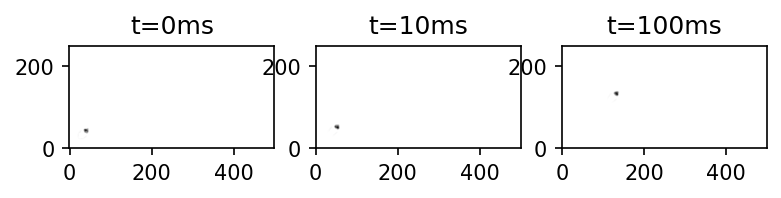

In [374]:
plot_timestamps(S_Tm2)

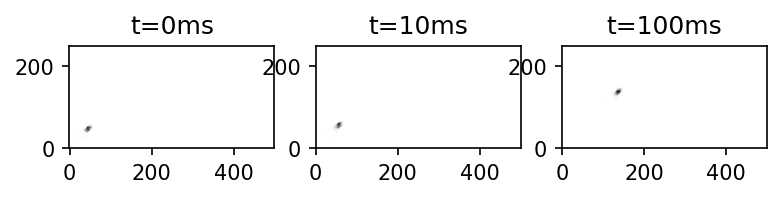

In [375]:
plot_timestamps(S_Tm1)

### Lobula (6070 only)

In [399]:
# compute spatiotemporal correlations

t_window = np.arange(0, 80, dt*1e3)
filter_eq25_4 = eq16_gamma(t_window, 3, 15)
filter_eq25_5 = eq16_gamma(t_window, 5, 25)
filter_eq25_6 = eq16_gamma(t_window, 8, 40)
S_Mi1_4 = convolve1d(S_Tm3, filter_eq25_4, mode='nearest', axis=0)
S_Tm1_5 = convolve1d(S_Tm2, filter_eq25_5, mode='nearest', axis=0)
S_Tm1_6 = convolve1d(S_Tm2, filter_eq25_6, mode='nearest', axis=0)



In [404]:
# alpha_1 = 3
# theta_ls = np.arange(0, 2, 1/4)*np.pi
# cos_ls = np.cos(theta_ls)
# sin_ls = np.sin(theta_ls)
rotation_ls = [(3,0), (2,2), (0,3), (-2,2), (-3,0), (-2,-2), (0,-3), (2,-2)]
non = lambda s: s if s<0 else None
mom = lambda s: max(0,s)

D = []
for rot in rotation_ls:
    S_Mi1_4_shifted = np.zeros_like(S_Mi1_4)
    print( mom(rot[0]), non(rot[0]), mom(rot[1]), non(rot[1]), mom(-rot[0]), non(-rot[0]), mom(-rot[1]), non(-rot[1]))
    S_Mi1_4_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Mi1_4[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]
    S_Tm1_6_shifted = np.zeros_like(S_Tm1_6)
    S_Tm1_6_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Tm1_6[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]
    D.append(S_Tm3*(S_Tm1_5+S_Mi1_4_shifted)*S_Tm1_6_shifted)

3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None


In [405]:
np.array(D).shape

(8, 400, 500, 250)

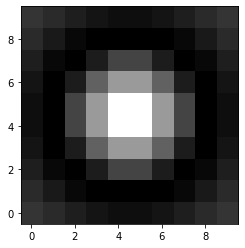

In [406]:
def eq21_g(x,y):
    return eq2_G(x,y,1.5) - eq2_G(x,y,3)

def eq20_W_2(x,y):
    return 1*np.clip(eq21_g(x,y), 0, np.inf) + 3*np.clip(eq21_g(x,y), -np.inf, 0)

X = np.linspace(-5, 5, num=10)
Y = np.linspace(-5, 5, num=10)
X, Y = np.meshgrid(X,Y)
filter_eq20 = eq20_W_2(X,Y)
plt.imshow(filter_eq20, origin='lower', cmap='gray')
plt.show()

In [407]:
D_I = np.zeros_like(D)
for ind in range(8):
    for t in range(400):
        D_I[ind, t] = convolve2d(D[ind][t], filter_eq20, mode='same', boundary='fill')
D_I = np.maximum(D_I, np.zeros_like(D_I))

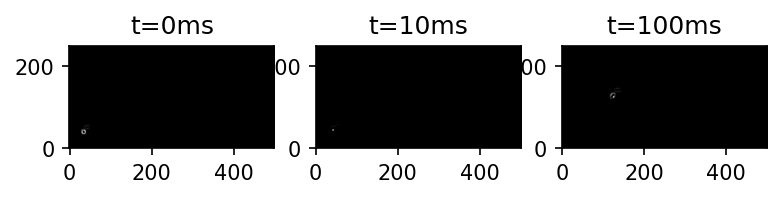

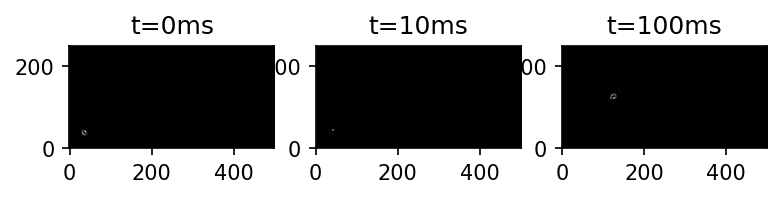

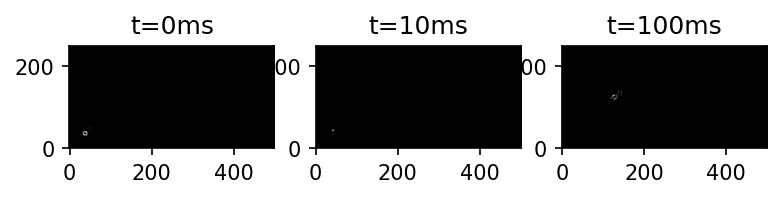

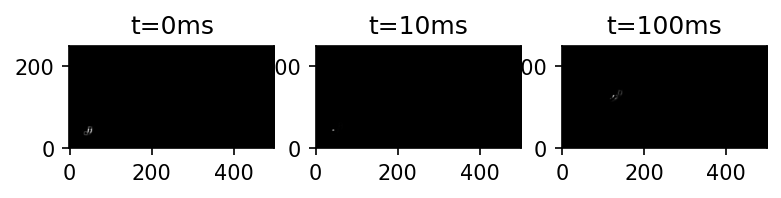

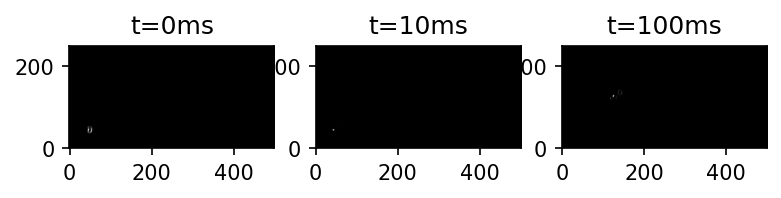

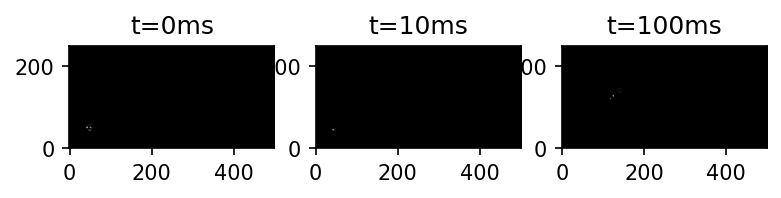

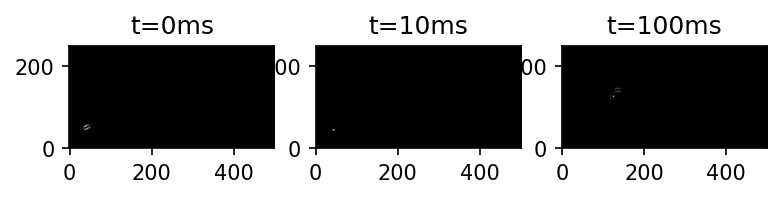

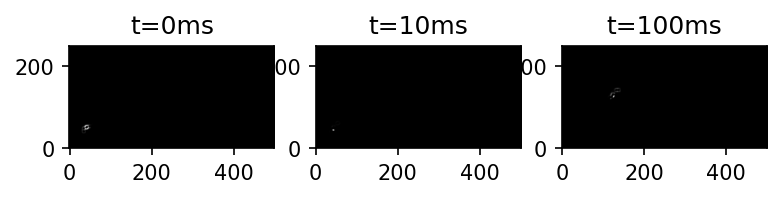

In [408]:
# rotation_ls = [(-2, -2)]
# non = lambda s: s if s<0 else None
# mom = lambda s: max(0,s)

# for rot in rotation_ls:
#     S_Mi1_4_shifted = np.zeros_like(S_Mi1_4)
#     print( mom(rot[0]), non(rot[0]), mom(rot[1]), non(rot[1]), mom(-rot[0]), non(-rot[0]), mom(-rot[1]), non(-rot[1]))
#     S_Mi1_4_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Mi1_4[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]
#     S_Tm1_6_shifted = np.zeros_like(S_Tm1_6)
#     S_Tm1_6_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Tm1_6[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]

# plot_timestamps(np.clip(S_Tm3*(S_Tm1_5+S_Mi1_4_shifted)*S_Tm1_6_shifted, -np.inf, np.inf))
for ind in range(8):
#     print(np.sum(D[ind][100]))
    plot_timestamps(D_I[ind])


### Evaluation

In [409]:
# visualize layerwise activations #
### All layer outputs are visualized above in their respective cells

In [433]:
# compare actual and estimated motion direction (6070 only) #
out_by_angle = []
for ind in range(8):
    out_by_angle.append(np.sum(D_I[ind][100]))
out_by_angle = np.array(out_by_angle)
out_by_angle /= np.max(out_by_angle)
out_by_angle # pi/4 is the largest

array([0.89218085, 1.        , 0.96922473, 0.32376022, 0.1074719 ,
       0.07215056, 0.11429788, 0.33122425])

### Above result shows that angle2 ((2,2), A.K.A. pi/4) has the strongest output, while the stimulus decays as the angle rotates away
### (ii) plot S(100ms)

In [437]:
def find_S(velocity, width=10):
    rect1 = {'dims': np.array([width, 10], dtype=int), # rectangle width, height (pixels)
         'p0': np.array([25, 25], dtype=int), # initial x,y position (pixels)
         'v': np.array([velocity, velocity], dtype=int), # x,y velocity (pixels/sec)
        }
    objects = [rect1] # collate objects

    # simulate object motion trajectories
    trajectories = [np.zeros((N, 2))] * len(objects)
    for m, obj in enumerate(objects):
        trajectories[m][0] = obj['p0']
    for i in range(1, N):
        # translate each object, with periodic screen boundaries
        for m, obj in enumerate(objects):
            trajectories[m][i] = np.remainder(trajectories[m][i-1] + dt * obj['v'], [W, H])

    # store ground truth object trajectory data
    ground_truth = []
    for m, obj in enumerate(objects):
        entry = {'dims': obj['dims'], 
                 'p': trajectories[m],
                }
        ground_truth.append(entry)

    # create input frames
    frames = []
    for i in range(N):
        frame = np.copy(background)
        for gt in ground_truth:
            w, h = gt['dims']
            px, py = gt['p'][i].astype(int)
            # draw within screen bounds
            frame[np.max([0, px]):np.min([px+w, W]), 
                  np.max([0, py]):np.min([py+h, H])] = 0
        frames.append(frame)
    frames = np.array(frames)
    
    # 1. retina
    P = []
    for t in range(len(frames)):
        P.append(eq1_P(frames[t]))
    # 2. lamina
    L = convolve1d(P, filter_eq4, mode='nearest', axis=0)
    L_I = convolve(L, W_1)
    # 3. medulla
    S_Tm3 = np.clip(L_I, 0, np.inf)
    S_Tm2 = np.clip(L_I, -np.inf, 0)
    # 4. lobula
    S_Mi1_4 = convolve1d(S_Tm3, filter_eq25_4, mode='nearest', axis=0)
    S_Tm1_5 = convolve1d(S_Tm2, filter_eq25_5, mode='nearest', axis=0)
    S_Tm1_6 = convolve1d(S_Tm2, filter_eq25_6, mode='nearest', axis=0)
    rotation_ls = [(3,0), (2,2), (0,3), (-2,2), (-3,0), (-2,-2), (0,-3), (2,-2)]
    non = lambda s: s if s<0 else None
    mom = lambda s: max(0,s)
    D = []
    for rot in rotation_ls:
        S_Mi1_4_shifted = np.zeros_like(S_Mi1_4)
        print( mom(rot[0]), non(rot[0]), mom(rot[1]), non(rot[1]), mom(-rot[0]), non(-rot[0]), mom(-rot[1]), non(-rot[1]))
        S_Mi1_4_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Mi1_4[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]
        S_Tm1_6_shifted = np.zeros_like(S_Tm1_6)
        S_Tm1_6_shifted[:, mom(-rot[0]):non(-rot[0]), mom(-rot[1]):non(-rot[1])] = S_Tm1_6[:, mom(rot[0]):non(rot[0]), mom(rot[1]):non(rot[1])]
        D.append(S_Tm3*(S_Tm1_5+S_Mi1_4_shifted)*S_Tm1_6_shifted)
    D_I = np.zeros_like(D)
    D_I[1][200] = convolve2d(D[1][200], filter_eq20, mode='same', boundary='fill') # speed-up
    D_I = np.maximum(D_I, np.zeros_like(D_I))
    return np.max(np.sum(D_I[1][200])) # pi/4 angle

In [443]:
velocity_ls = np.linspace(0, 1000, 11)
velocity_result = []
for v in velocity_ls:
    print(v)
    velocity_result.append(find_S(v, 5))

0.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
100.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
200.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
300.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
400.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 N

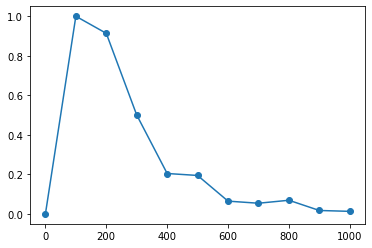

In [446]:
plt.plot(velocity_ls, velocity_result/np.max(velocity_result), '-o')

In [449]:
width_ls = np.linspace(0, 20, 21)
width_result = []
for w in width_ls:
    print(w)
    width_result.append(find_S(100, w))
width_result

0.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
1.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
2.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
3.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 None 0 -2 0 -2 2 None
4.0
3 None 0 None 0 -3 0 None
2 None 2 None 0 -2 0 -2
0 None 3 None 0 None 0 -3
0 -2 2 None 2 None 0 -2
0 -3 0 None 3 None 0 None
0 -2 0 -2 2 None 2 None
0 None 0 -3 0 None 3 None
2 No

[0.0,
 9.445210871930887e-06,
 8.654013144351709e-05,
 0.00022837111024444495,
 0.00032852674799525714,
 0.0003236772490015545,
 0.0002490740674762394,
 0.00019561776853438235,
 0.0001812481934369139,
 0.00018133392406383223,
 0.00017967078743527022,
 0.00017148859386942482,
 0.00016406528155493363,
 0.00016205106281987227,
 0.00017573493190719565,
 0.00019658986544464742,
 0.00021802388903270503,
 0.0002192810345366287,
 0.0002212260454362608,
 0.00021191399819343084,
 0.00019616631688124139]

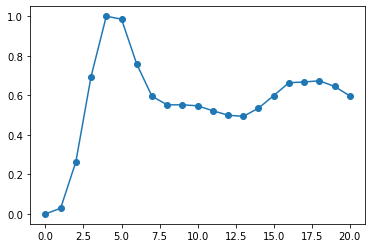

In [450]:
plt.plot(width_ls, width_result/np.max(width_result), '-o')